In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t, linregress
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import r2_score
from pingouin import ancova
from sklearn.manifold import MDS
from sklearn.metrics import DistanceMetric
from scipy.spatial import ConvexHull
import matplotlib.patches as patches
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import f
from itertools import permutations
import warnings
warnings.filterwarnings('ignore')
from umap import umap_ as UMAP
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from sklearn.metrics import pairwise_distances
import itertools

# Data loading and cleaning

In [2]:
df = pd.read_excel('FINAL DRY + DRAINAGE PLANT COMMUNITIES MAIN MATRIX WTMW.xlsx')
df.shape

(102, 34)

In [3]:
geo_df = pd.read_excel('Channel morphology.xls').loc[:52]
geo_df.shape

(53, 15)

In [4]:
geo_merge = geo_df[['Site #', 'Geomorphic surface']]
geo_merge.head()

,Site #,Geomorphic surface
0,0.0,1
1,1.0,1
2,2.0,1
3,3.0,1
4,4.0,1


In [5]:
df.columns = df.iloc[2]
df = df[3:].reset_index(drop = True)
df.rename(columns = {np.nan : 'site'}, inplace = True)

In [6]:
upland_index = df[df.site.str.contains('d')].index
df['uplands'] = 0
df.loc[upland_index, 'uplands'] = 1

In [7]:
df.uplands.value_counts()

uplands
0    53
1    46
Name: count, dtype: int64

In [8]:
df.site = df.site.str.replace('d', '').astype(int)

In [9]:
df['site'] = df.site.astype(int)

In [10]:
df = df.astype(float)

In [11]:
tdf = df.merge(geo_merge, left_on = 'site', right_on = 'Site #', how = 'left')
tdf.shape

(99, 37)

In [12]:
tdf['Geomorphic surface'].value_counts()

Geomorphic surface
2    52
1    24
3    13
4    10
Name: count, dtype: int64

In [13]:
tdf.rename(columns=lambda x: x.strip(), inplace=True)

In [14]:
tdf['richness'] = tdf.drop(columns = ['site', 'uplands', 'Site #', 'Geomorphic surface']).apply(lambda x: (x != 0).sum(), axis = 1)

In [15]:
tdf['distance'] = tdf.site * 0.25

In [16]:
tdf.max().sort_values().head(15)

T.amer                 0.4
Sphear                 0.8
Steph                  0.8
Buckwhe                0.8
grass                  0.8
uplands                1.0
O.engl                 3.1
E.engle                3.2
F.cyl                  3.2
Geomorphic surface       4
H.mono                 6.3
A.dum                  6.4
S.mex                  6.4
K.grey                12.8
O.big                 12.8
dtype: object

In [17]:
tdf.drop(columns = ['T.amer', 'Buckwhe', 'grass', 'Sphear', 'Steph', 'O.engl', 'F.cyl', 'E.engle', 'Site #'], inplace = True)

In [18]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   site                99 non-null     float64
 1   P.micro             99 non-null     float64
 2   B.jun               99 non-null     float64
 3   A.greg              99 non-null     float64
 4   S.mex               99 non-null     float64
 5   Lycium2             99 non-null     float64
 6   Lycium1             99 non-null     float64
 7   S.chin              99 non-null     float64
 8   E.far               99 non-null     float64
 9   A.delt              99 non-null     float64
 10  L.tri               99 non-null     float64
 11  E.tri               99 non-null     float64
 12  H.emory             99 non-null     float64
 13  A.oides             99 non-null     float64
 14  K.grey              99 non-null     float64
 15  F.splen             99 non-null     float64
 16  C.gig     

# Data exploration

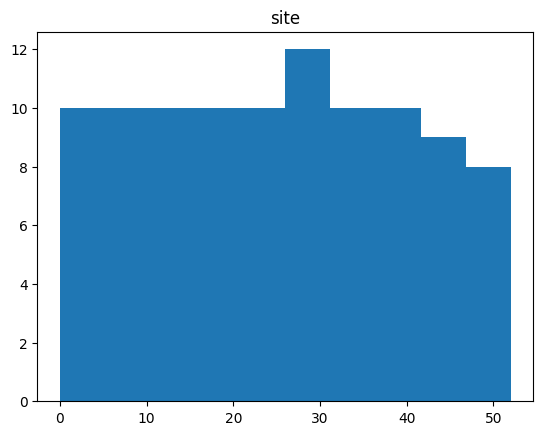

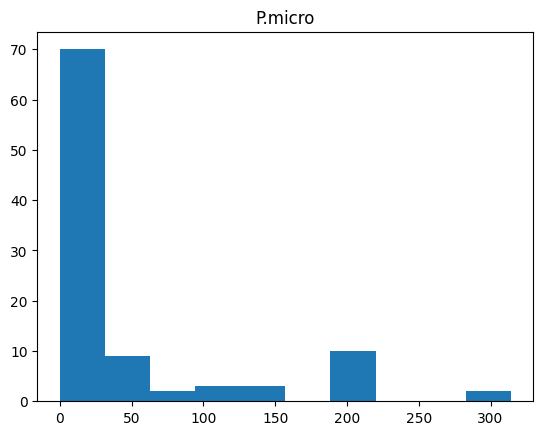

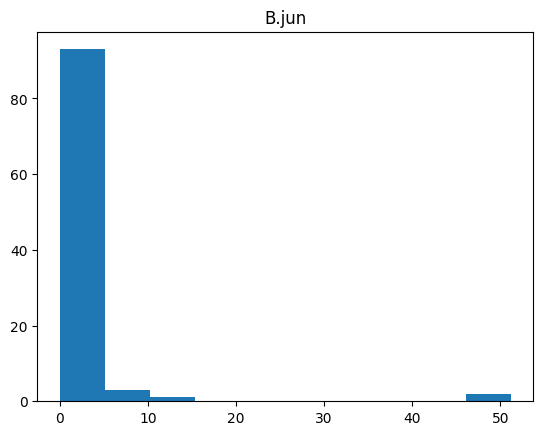

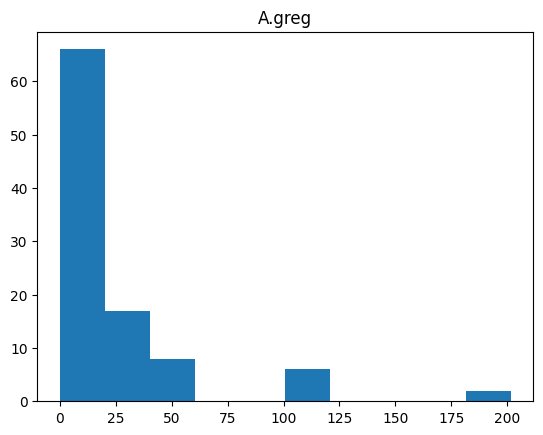

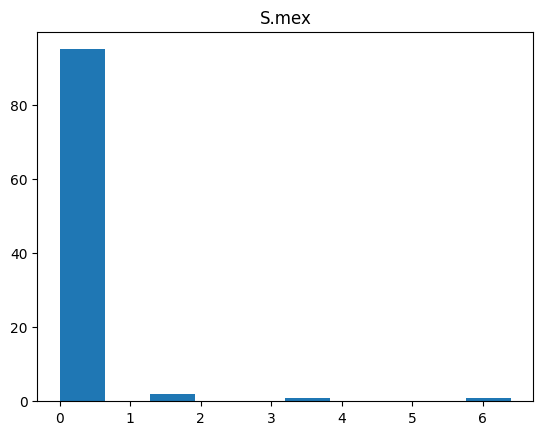

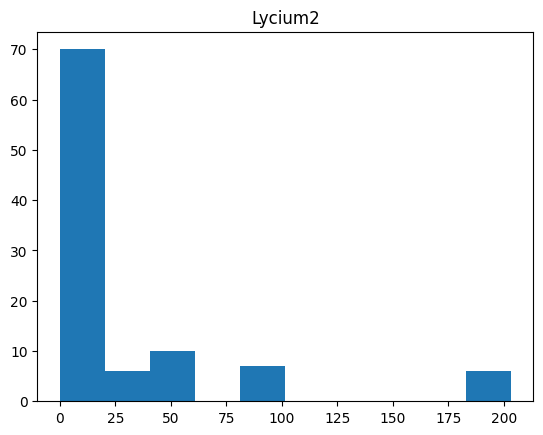

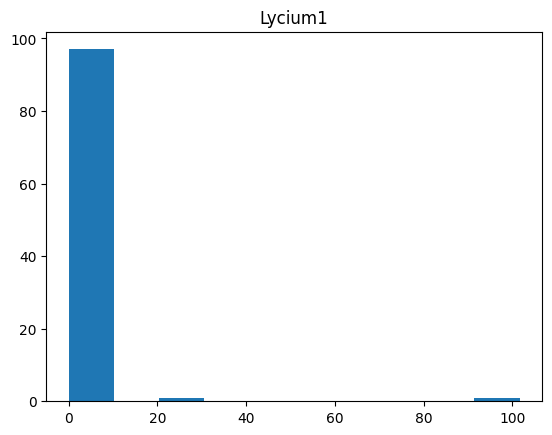

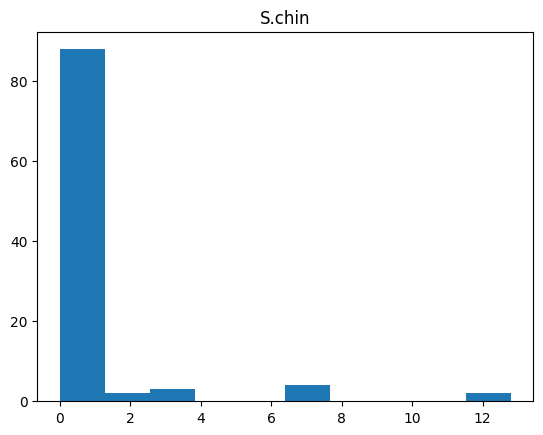

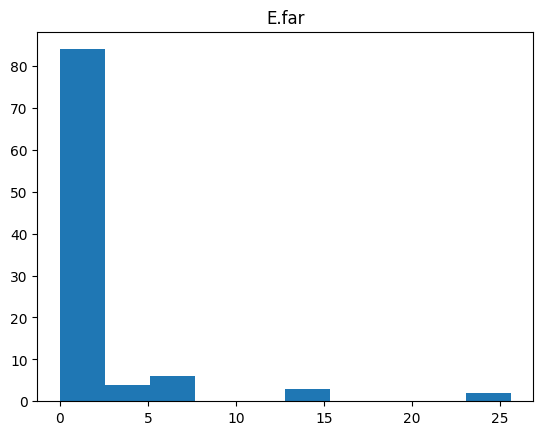

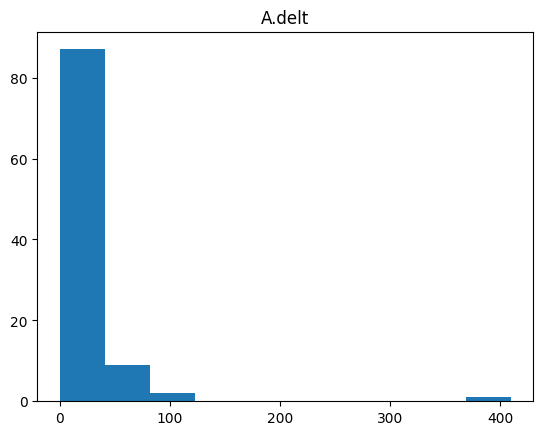

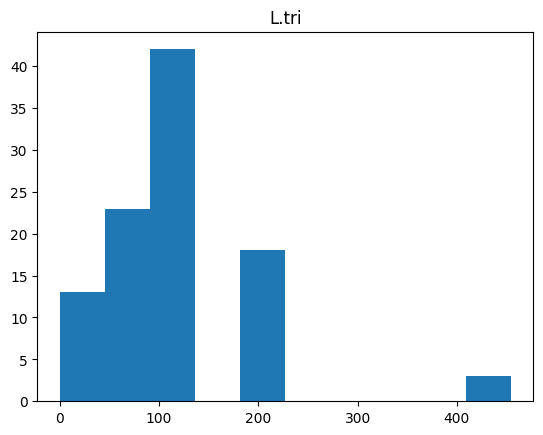

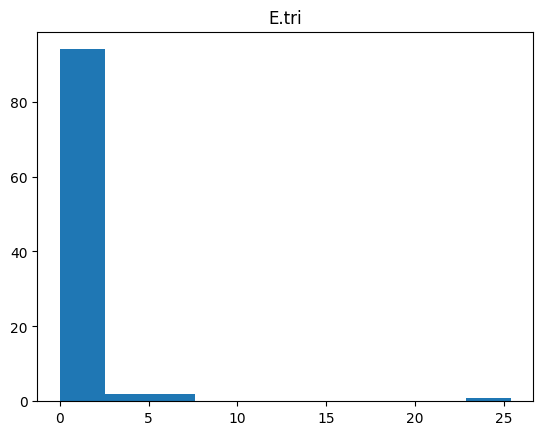

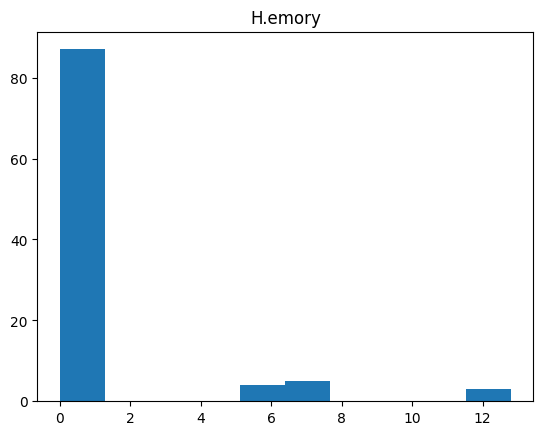

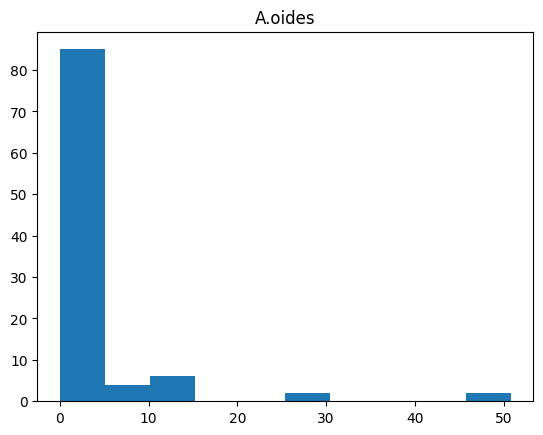

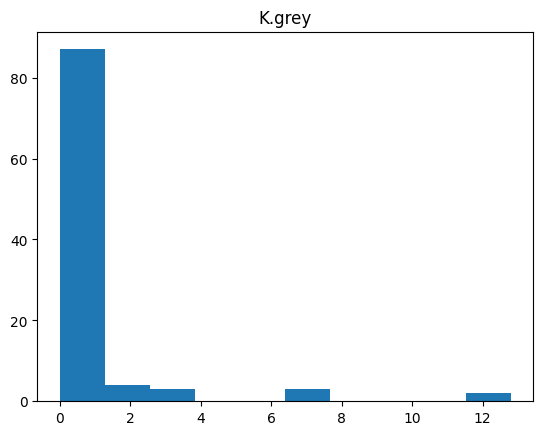

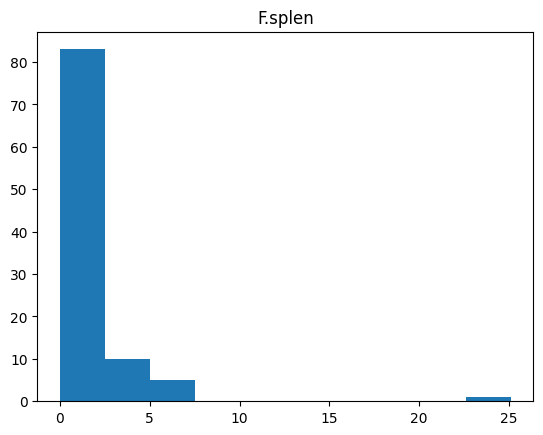

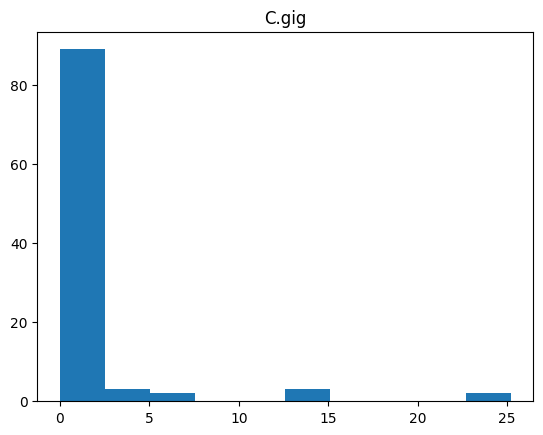

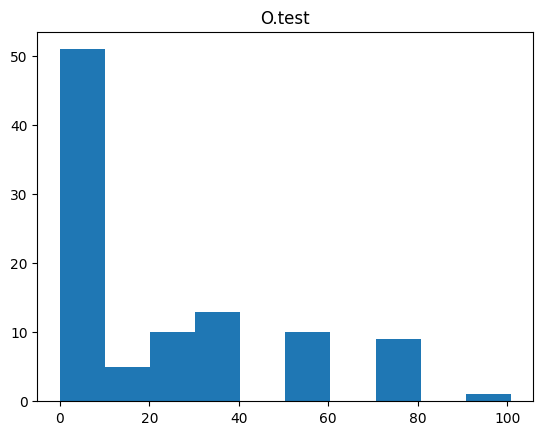

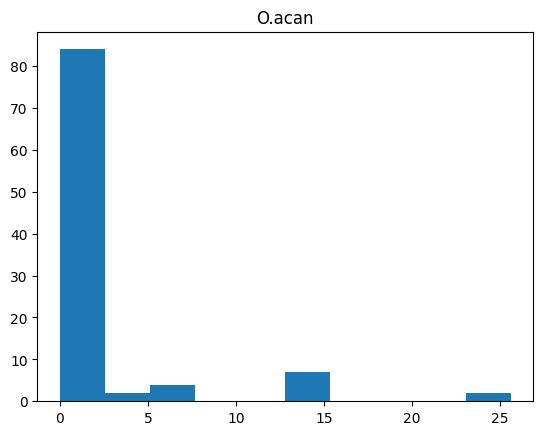

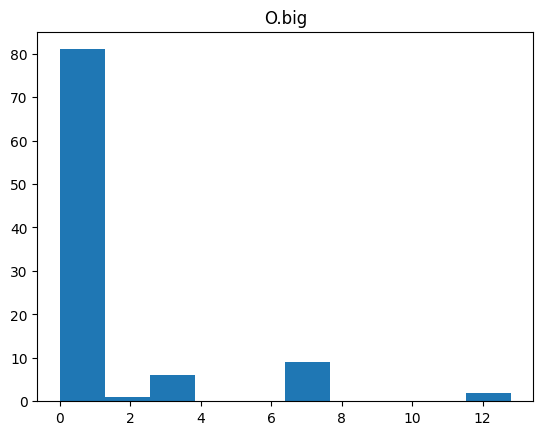

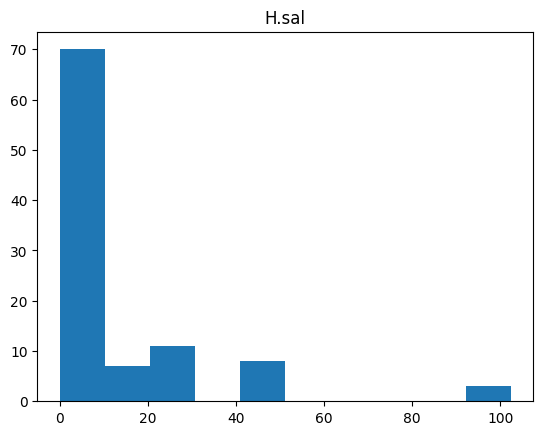

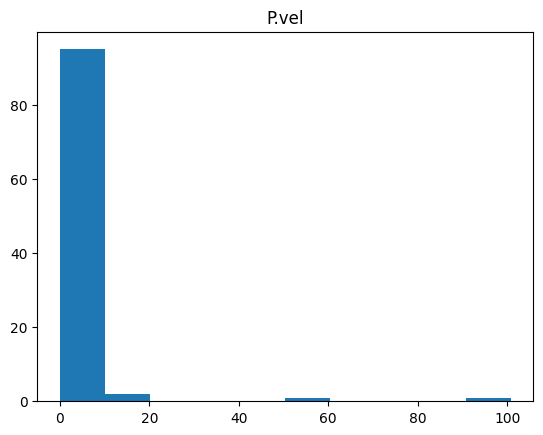

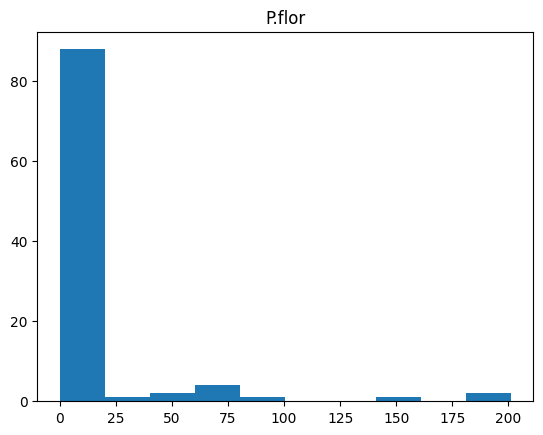

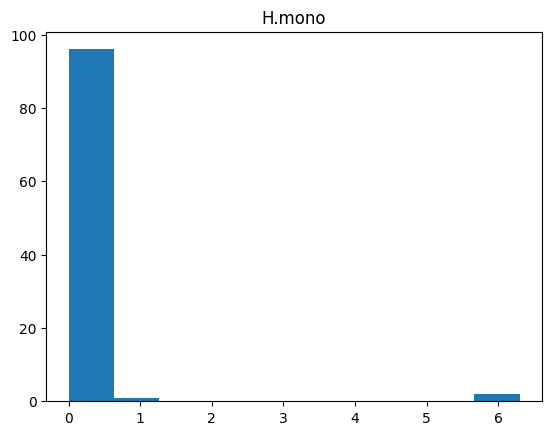

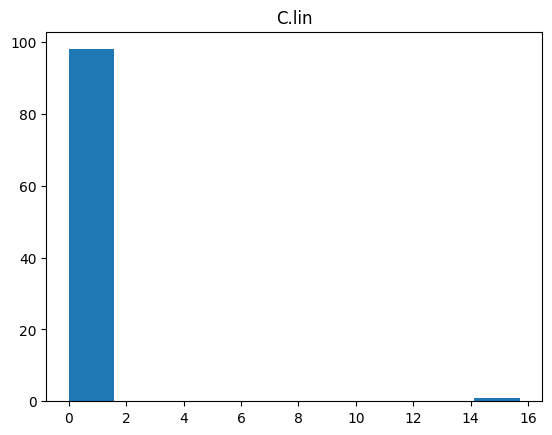

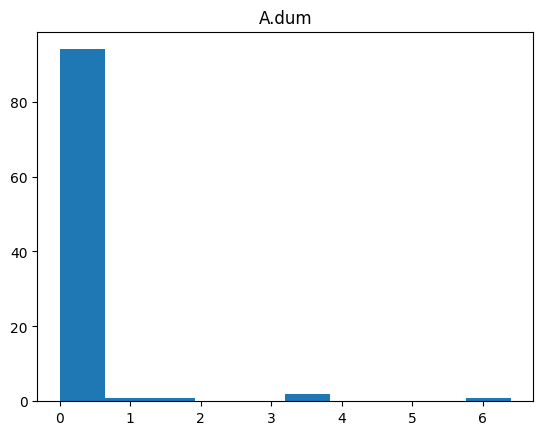

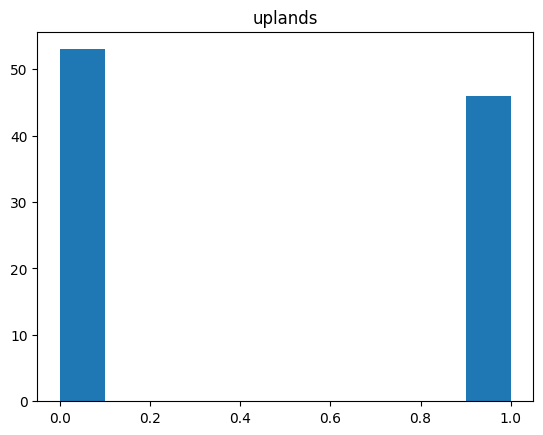

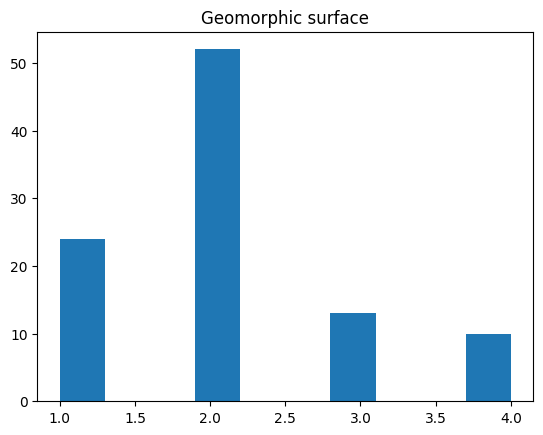

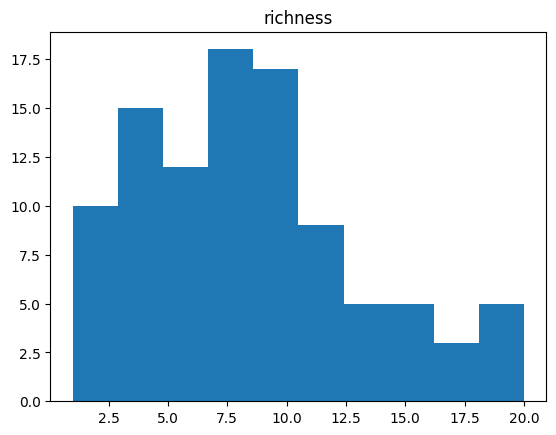

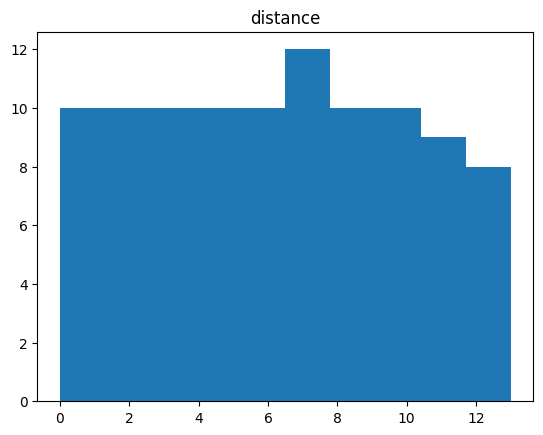

In [19]:
for i in tdf.columns:
    plt.hist(tdf[i])
    plt.title(i)
    plt.show()

All distributions are extremely non-normal, will need to use non-parametric models

In [20]:
drainage = tdf[tdf.uplands == 0].groupby(['Geomorphic surface']).mean()
uplands = tdf[tdf.uplands == 1].groupby(['Geomorphic surface']).mean()

In [21]:
tdf.columns

Index(['site', 'P.micro', 'B.jun', 'A.greg', 'S.mex', 'Lycium2', 'Lycium1',
       'S.chin', 'E.far', 'A.delt', 'L.tri', 'E.tri', 'H.emory', 'A.oides',
       'K.grey', 'F.splen', 'C.gig', 'O.test', 'O.acan', 'O.big', 'H.sal',
       'P.vel', 'P.flor', 'H.mono', 'C.lin', 'A.dum', 'uplands',
       'Geomorphic surface', 'richness', 'distance'],
      dtype='object')

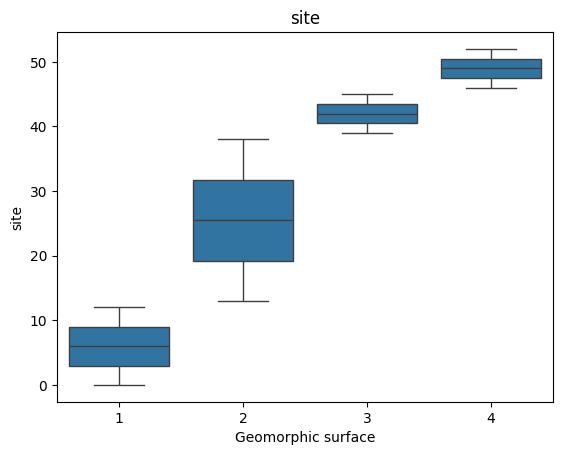

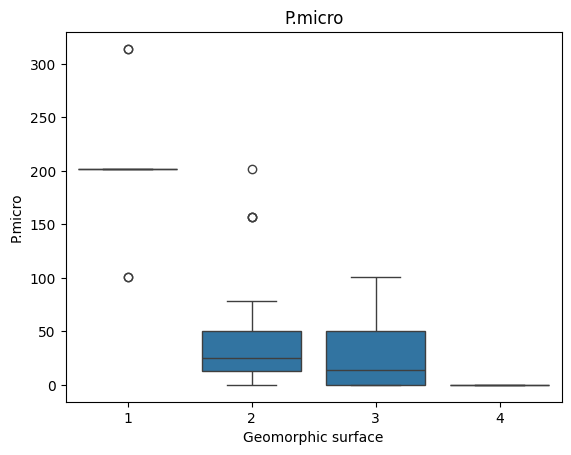

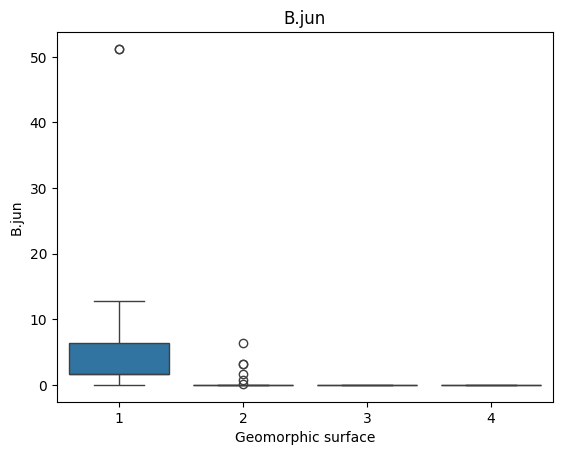

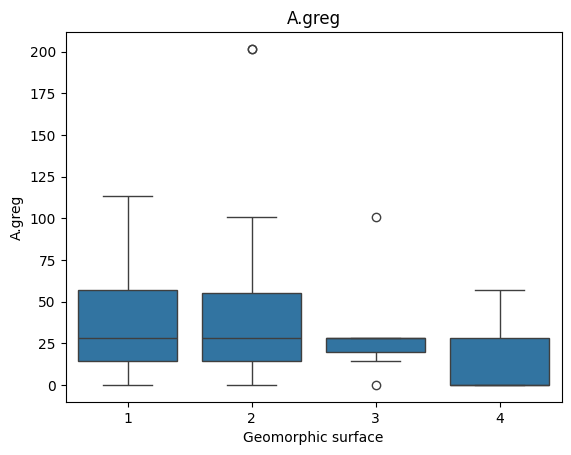

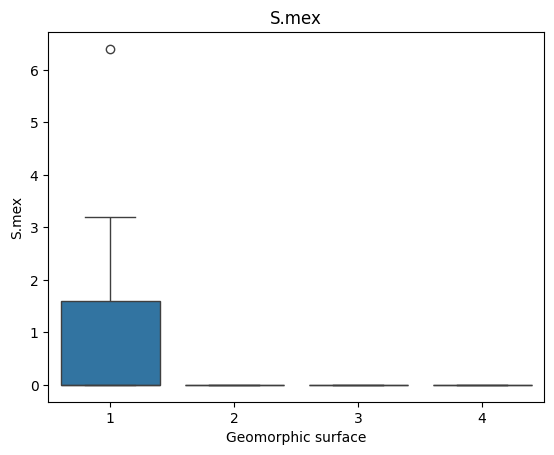

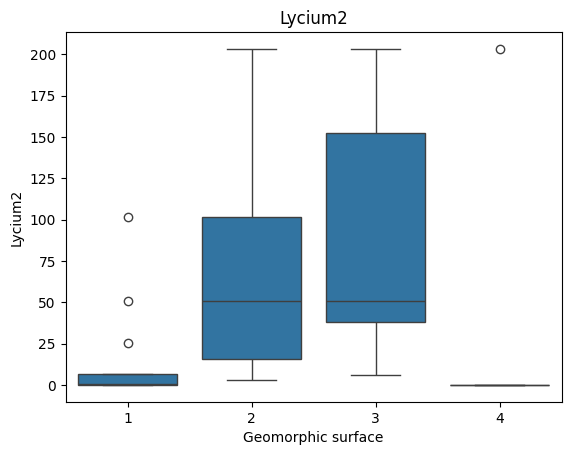

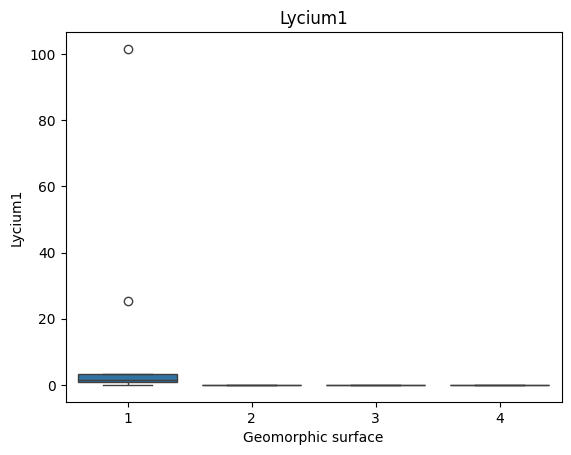

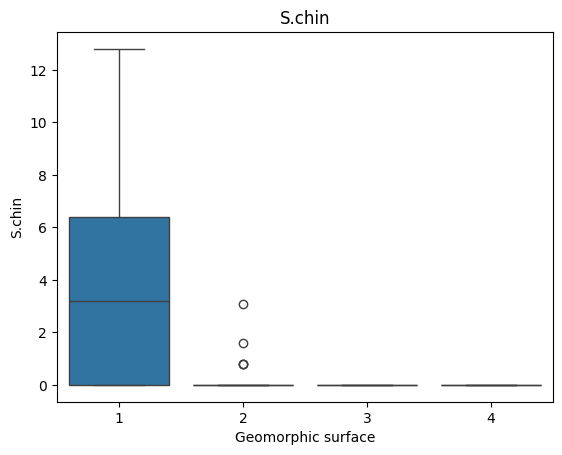

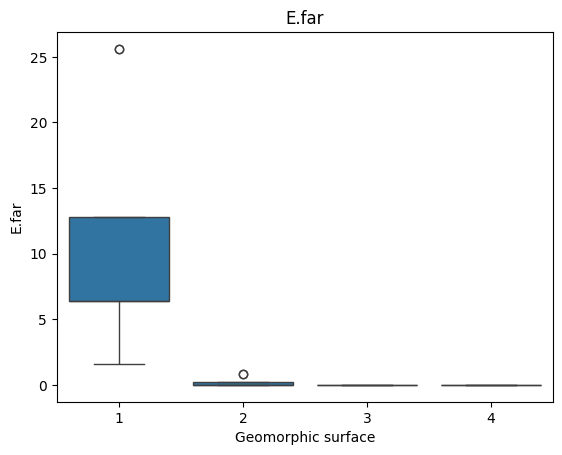

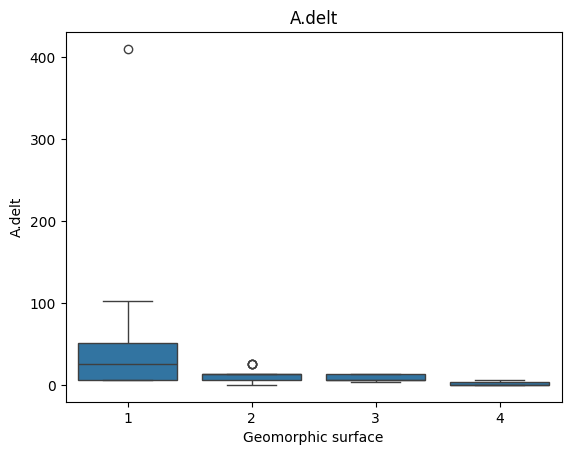

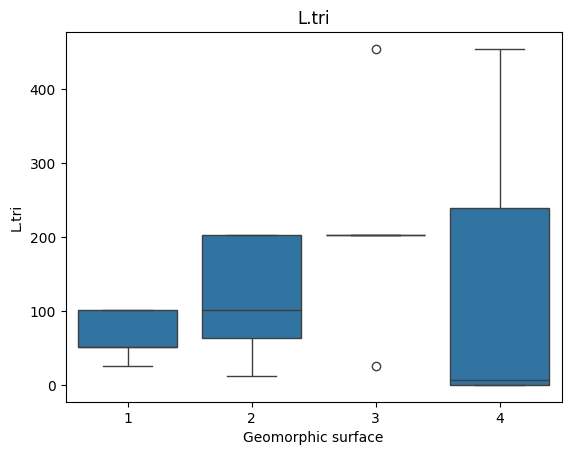

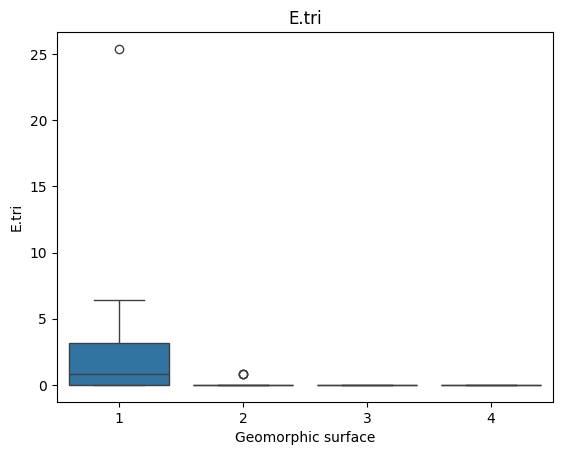

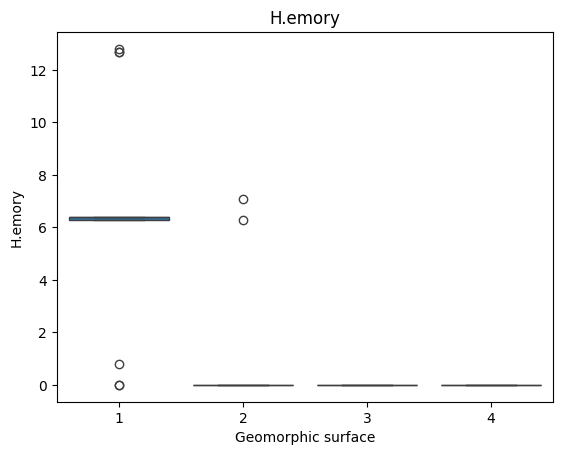

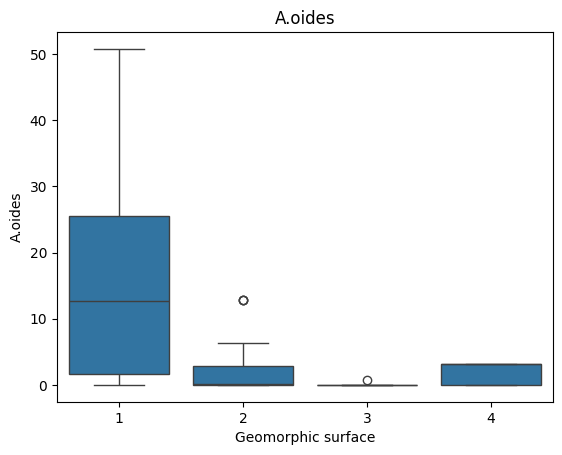

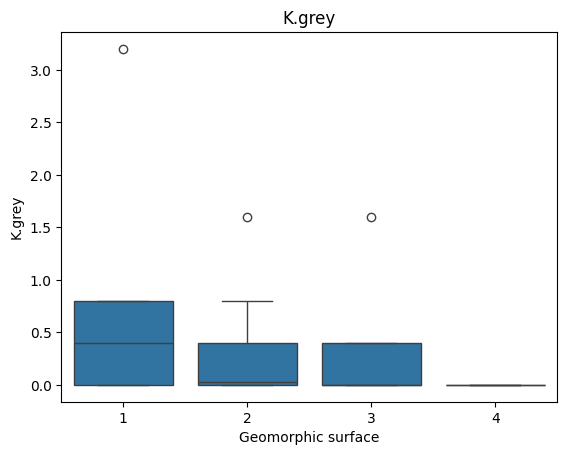

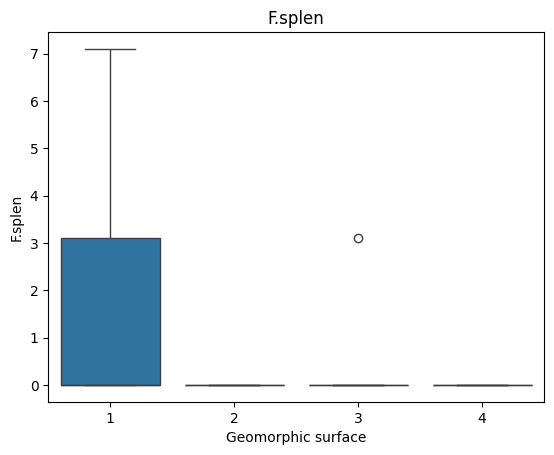

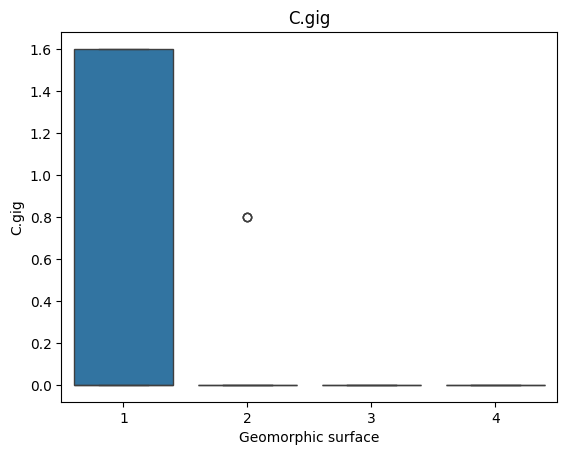

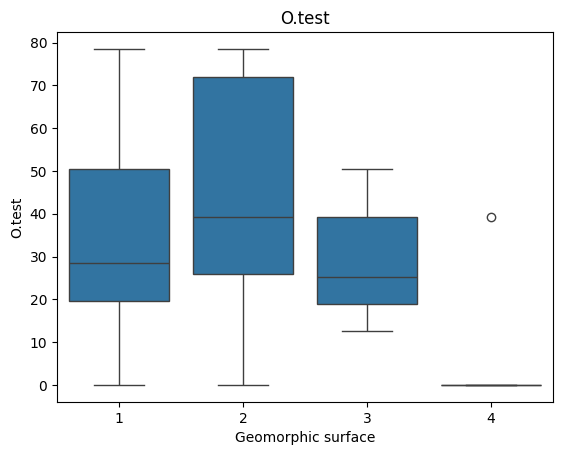

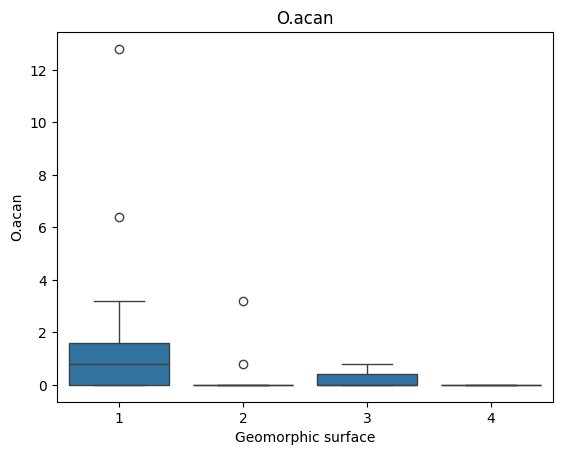

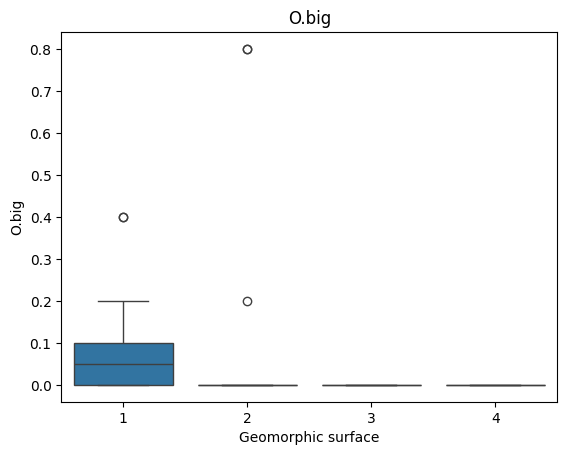

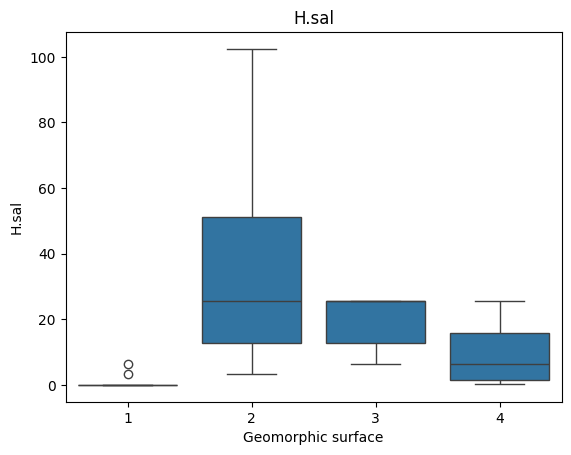

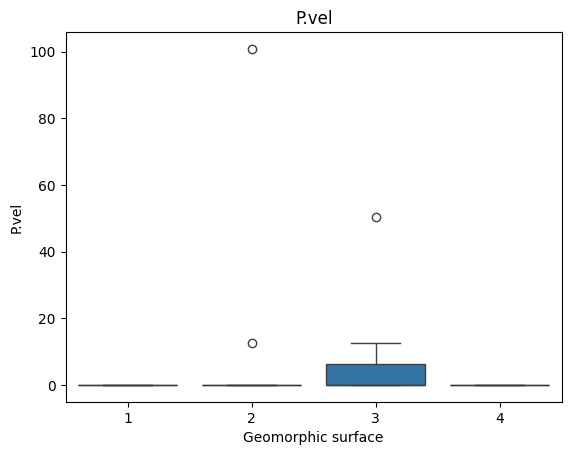

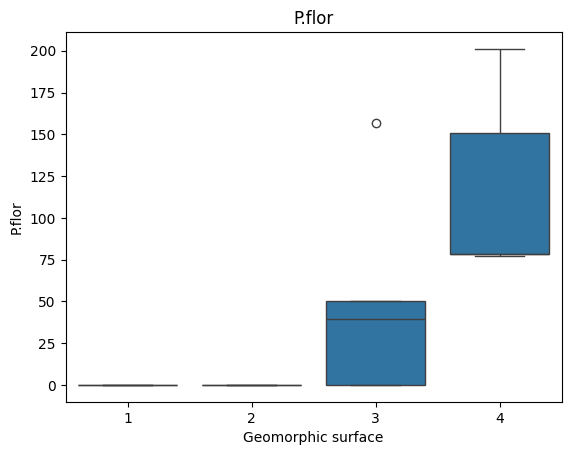

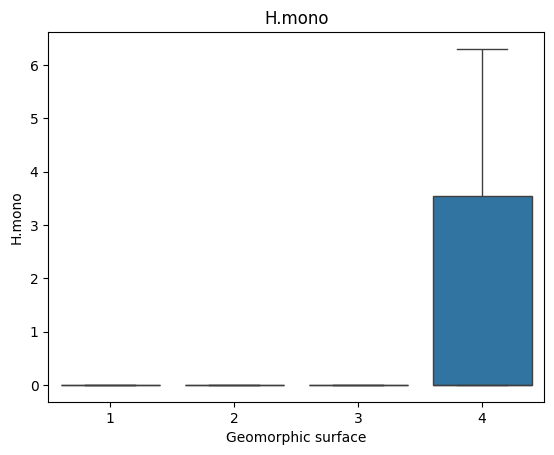

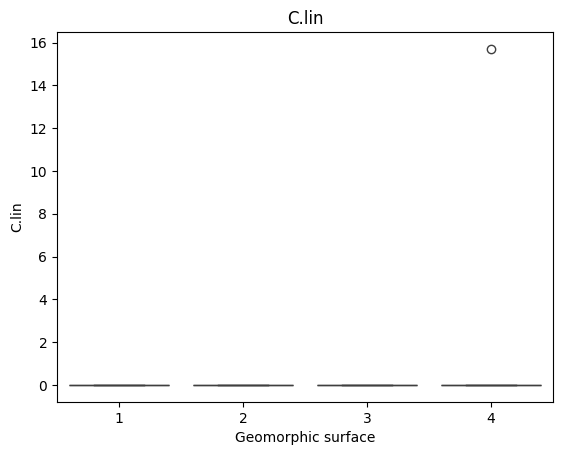

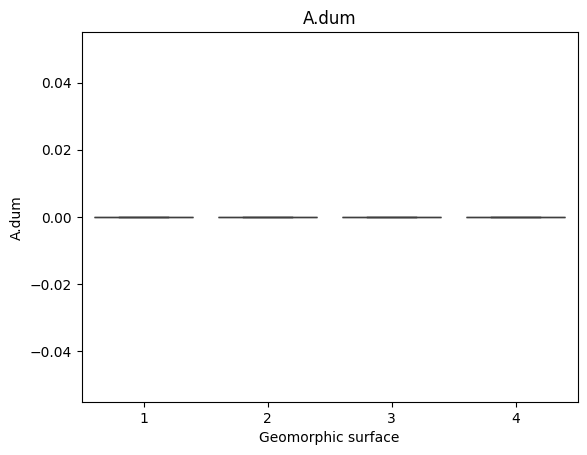

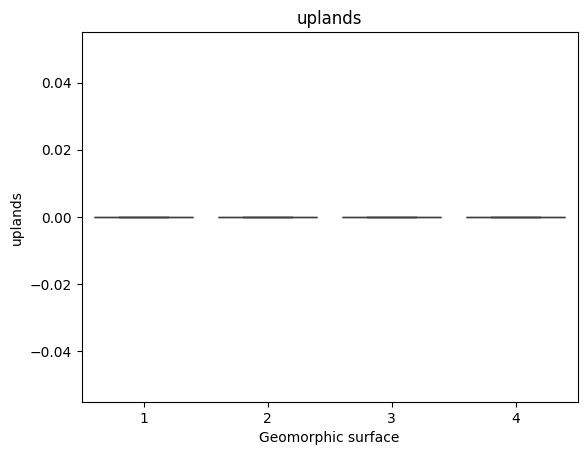

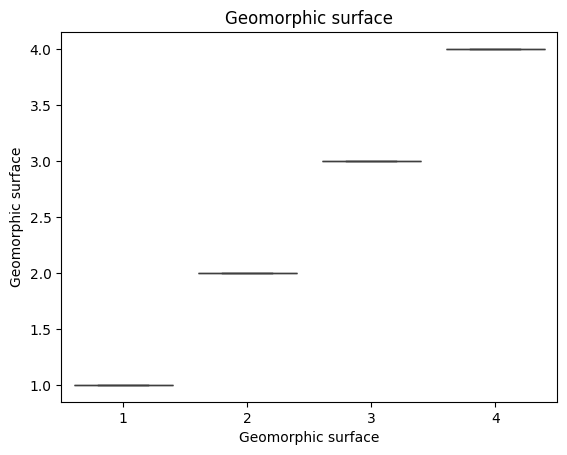

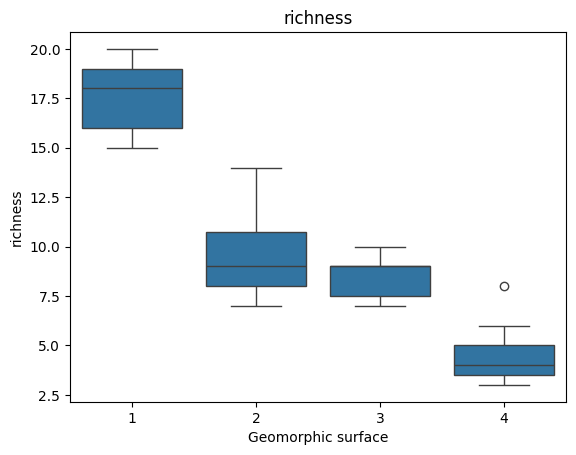

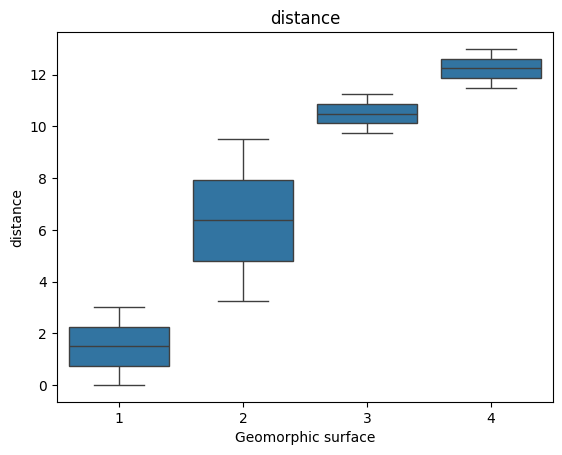

In [22]:
for i in tdf.columns:
    sns.boxplot(data = tdf[tdf.uplands == 0], x = 'Geomorphic surface', y = i)
    plt.title(i)
    plt.show()

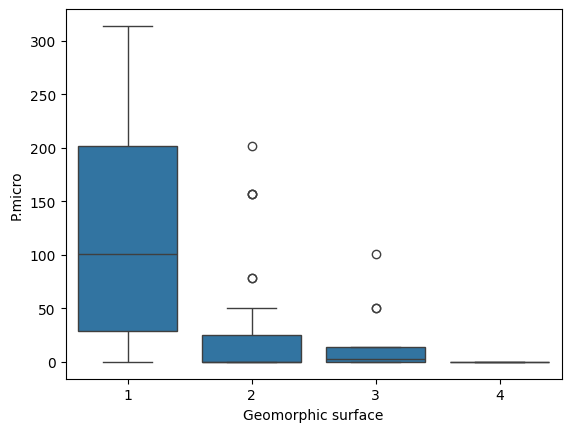

In [23]:
sns.boxplot(data = tdf, x = 'Geomorphic surface', y = 'P.micro')
plt.show()

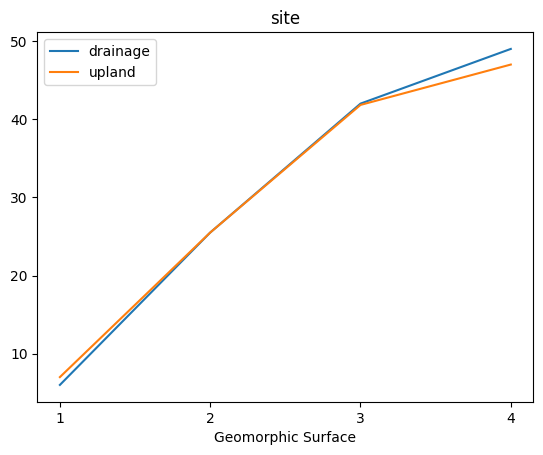

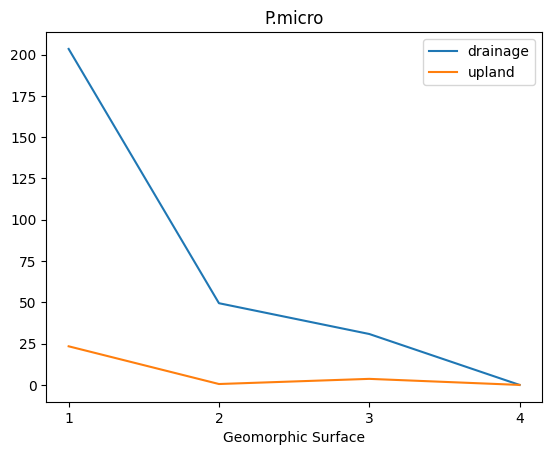

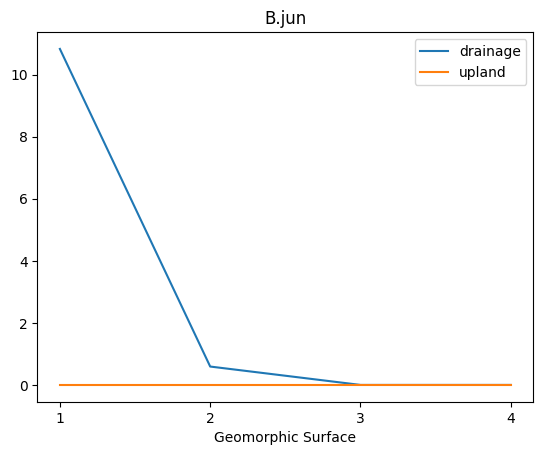

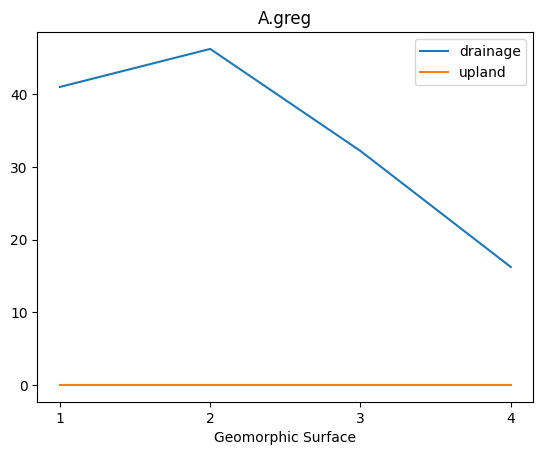

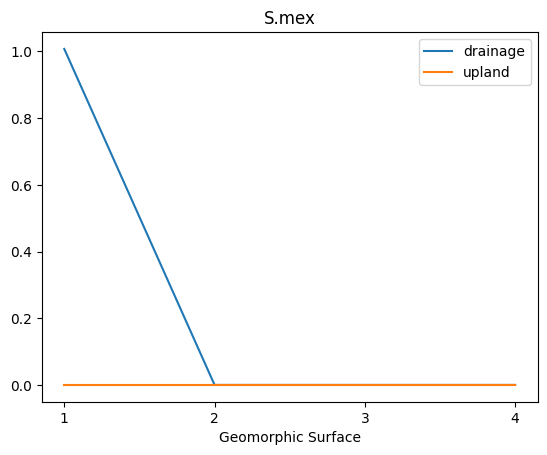

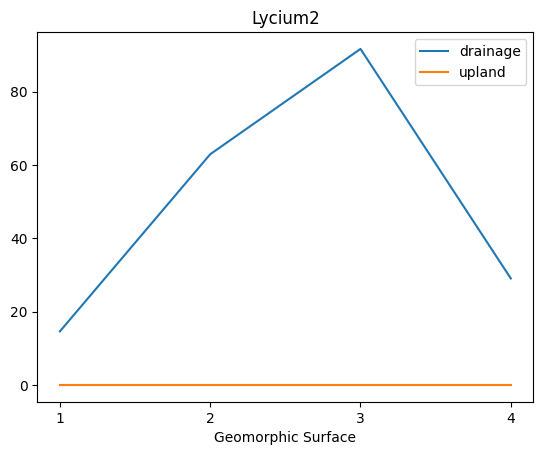

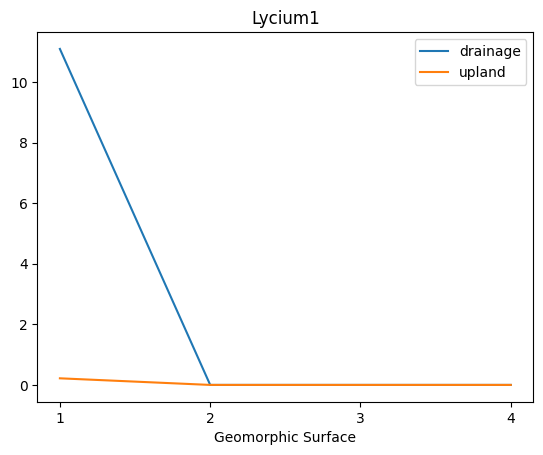

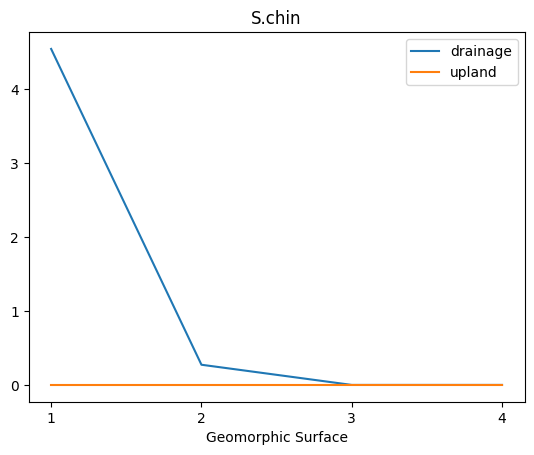

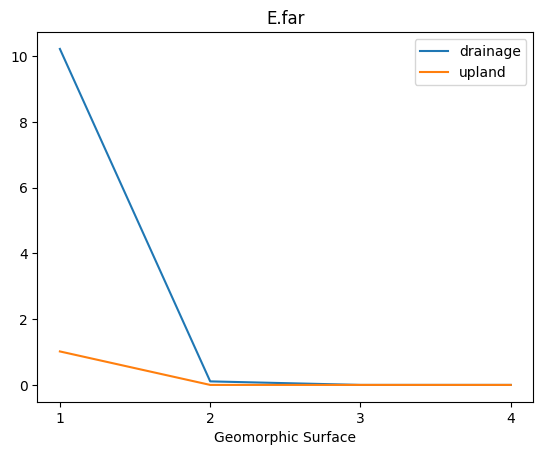

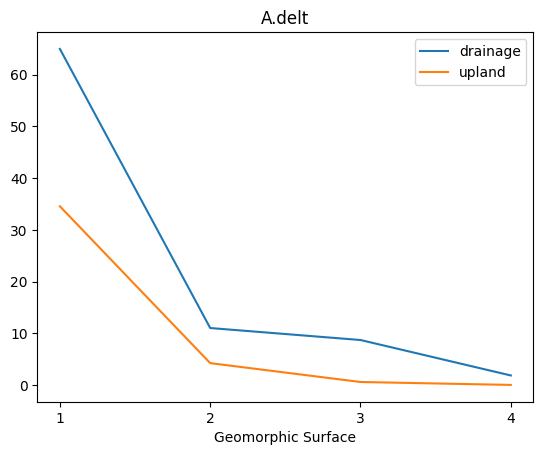

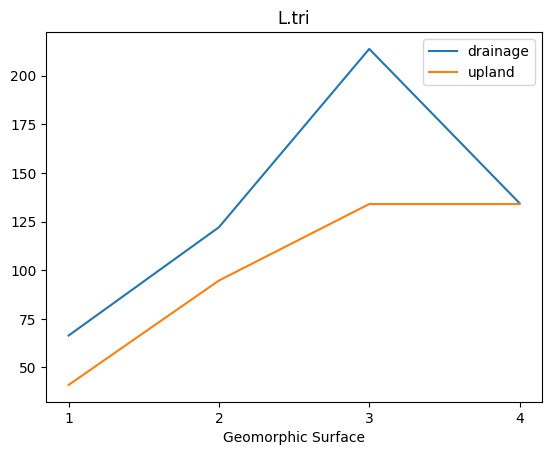

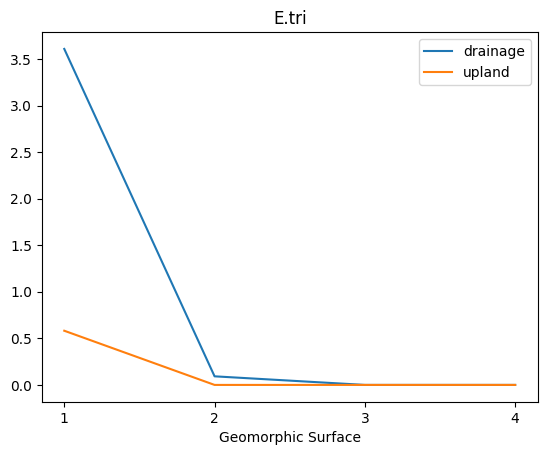

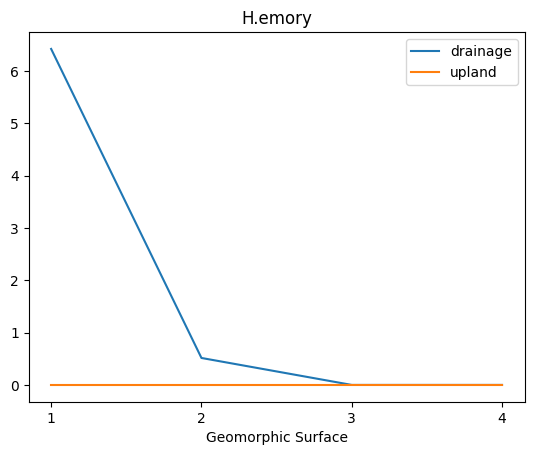

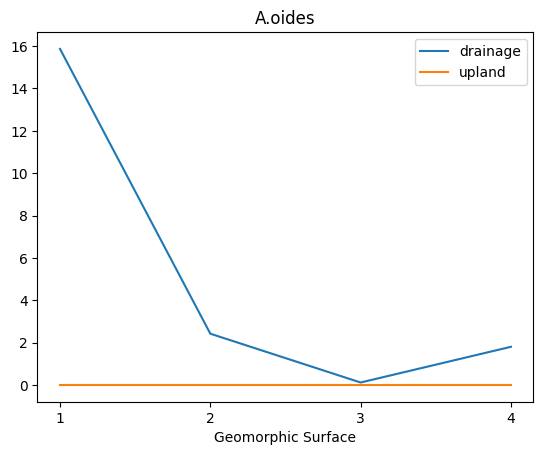

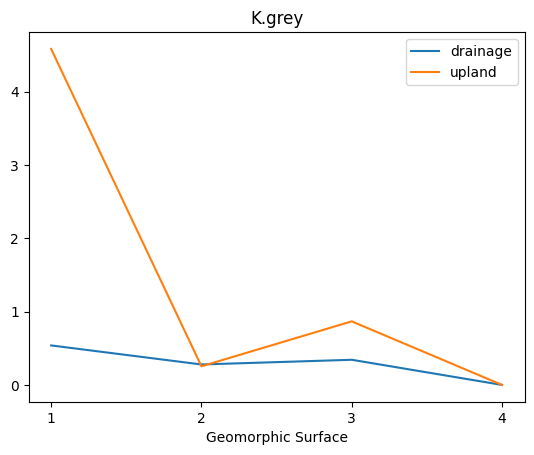

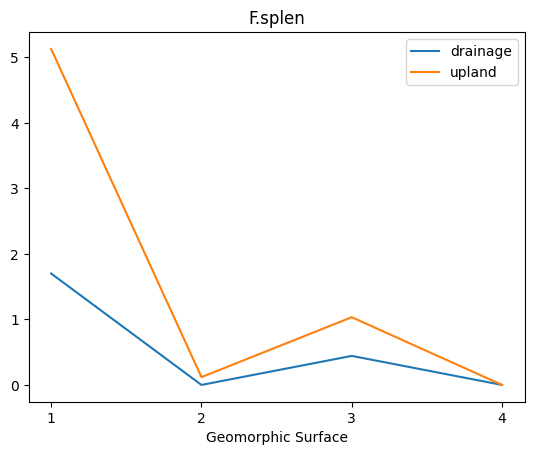

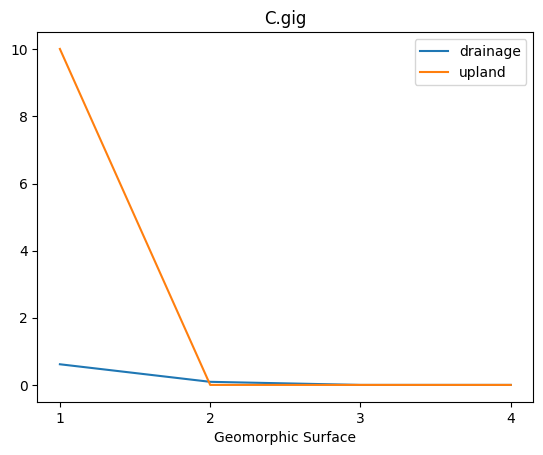

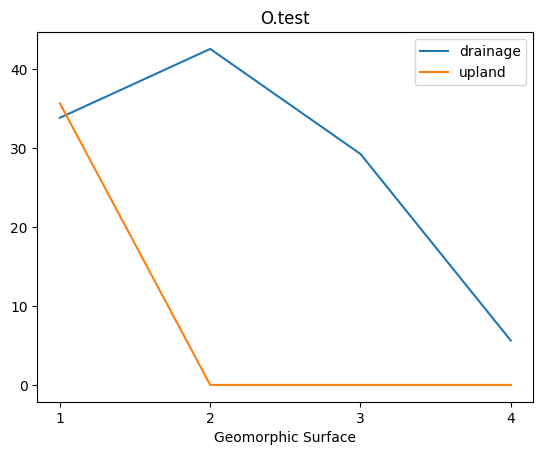

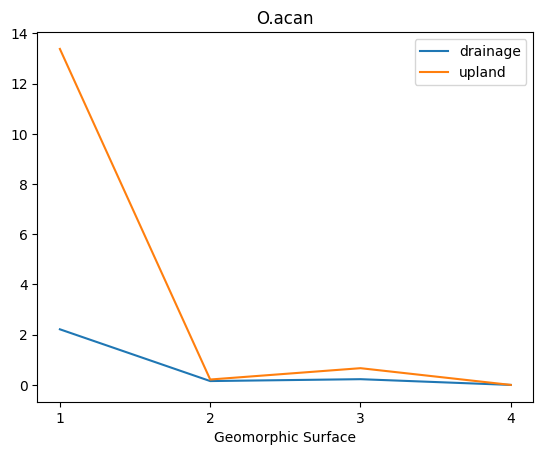

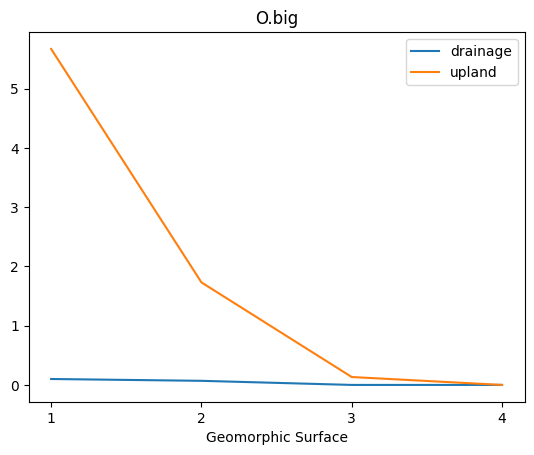

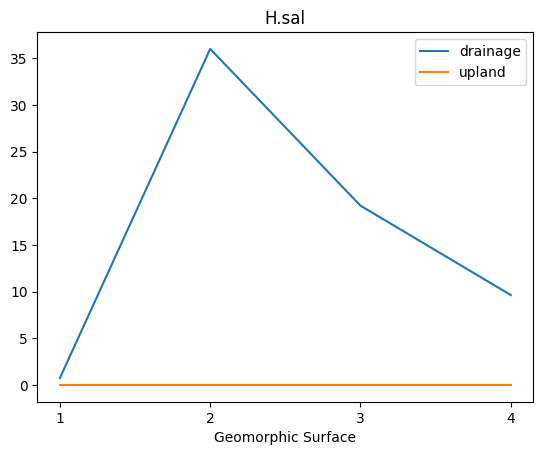

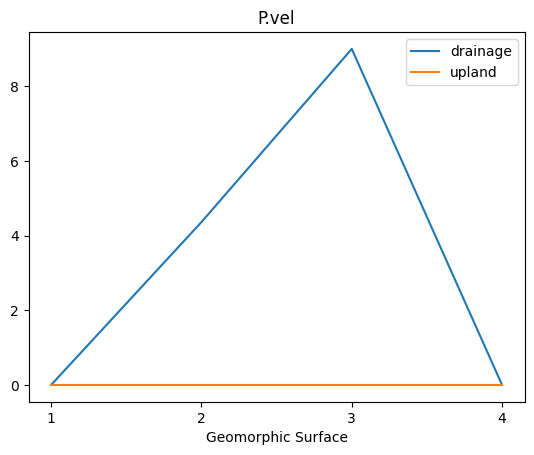

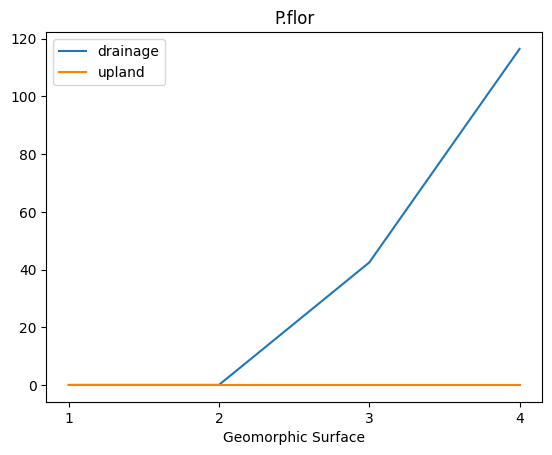

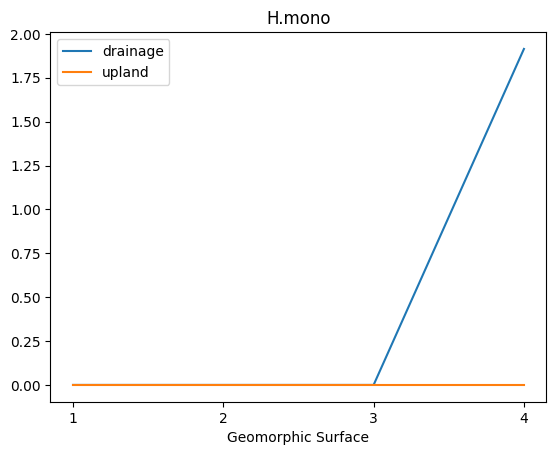

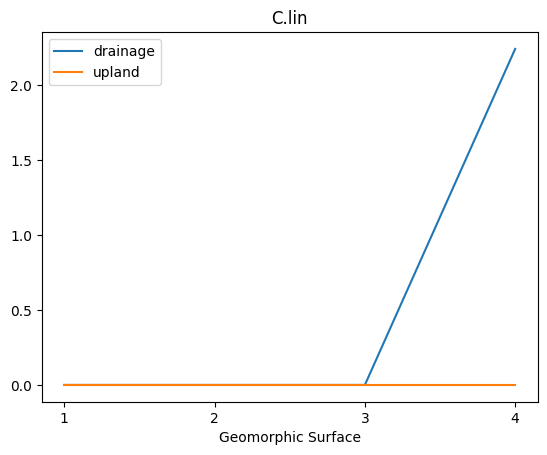

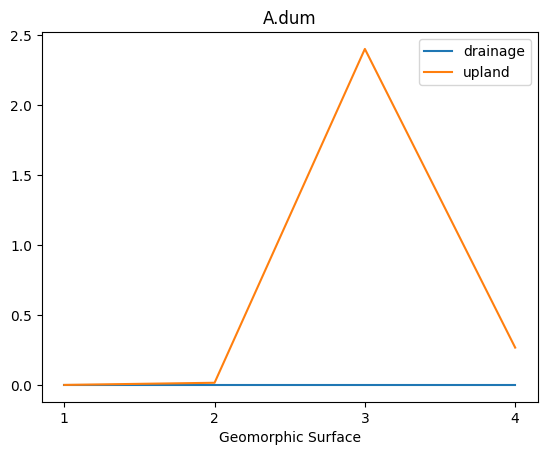

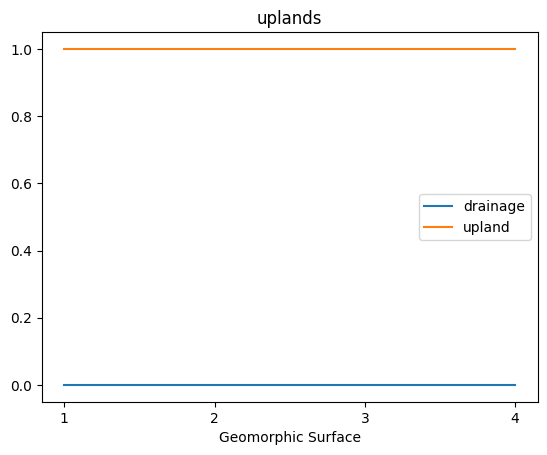

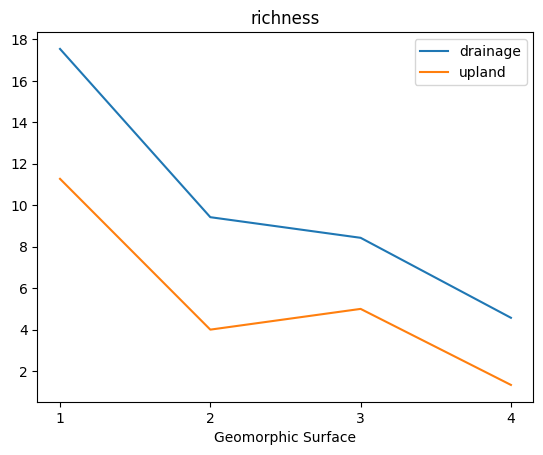

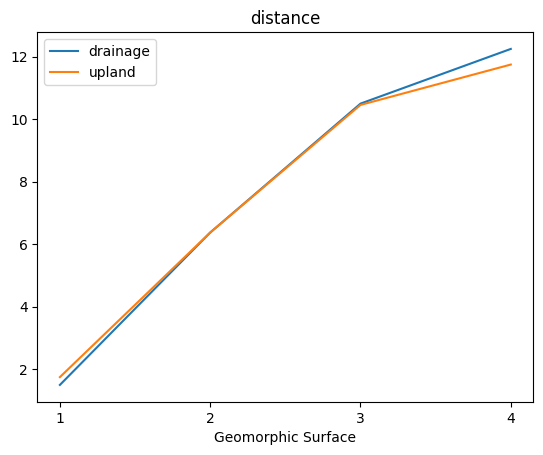

In [24]:
for i in drainage.columns:
    plt.plot(drainage.index, drainage[i], label = 'drainage')
    plt.plot(drainage.index, uplands[i], label = 'upland')
    plt.legend()
    plt.xticks([1, 2, 3, 4], [1, 2, 3, 4])
    plt.title(i)
    plt.xlabel('Geomorphic Surface')
    plt.show()

# Linear regression uplands vs drainage species richness

In [25]:
dX = sm.add_constant(tdf[tdf.uplands == 0].distance)
dmodel = sm.OLS(tdf[tdf.uplands == 0].richness, dX).fit()
dconf_intervals = dmodel.conf_int()
dpred = dmodel.get_prediction(dX)
dpred_summary = dpred.summary_frame(alpha=0.05)  # 95% confidence intervals
# Extract confidence intervals
dci_lower = dpred_summary['mean_ci_lower']
dci_upper = dpred_summary['mean_ci_upper']
dpi_lower = dpred_summary['obs_ci_lower']
dpi_upper = dpred_summary['obs_ci_upper']
#dmodel.summary()

In [26]:
dr2 = r2_score(tdf[tdf.uplands == 0].richness, dmodel.fittedvalues)
print('Drainage')
print('p-value =', dmodel.pvalues.values[1])
print('r2 =', dr2)

Drainage
p-value = 5.429208129824995e-18
r2 = 0.771844974546987


In [27]:
uX = sm.add_constant(tdf[tdf.uplands == 1].distance)
umodel = sm.OLS(tdf[tdf.uplands == 1].richness, uX).fit()
uconf_intervals = umodel.conf_int()
upred = umodel.get_prediction(uX)
upred_summary = upred.summary_frame(alpha=0.05)  # 95% confidence intervals
# Extract confidence intervals
uci_lower = upred_summary['mean_ci_lower']
uci_upper = upred_summary['mean_ci_upper']
upi_lower = upred_summary['obs_ci_lower']
upi_upper = upred_summary['obs_ci_upper']
#umodel.summary()

In [28]:
ur2 = r2_score(tdf[tdf.uplands == 1].richness, umodel.fittedvalues)
print('Uplands')
print('p-value =', umodel.pvalues.values[1])
print('r2 =', ur2)

Uplands
p-value = 1.9342757413960126e-10
r2 = 0.6057951090033291


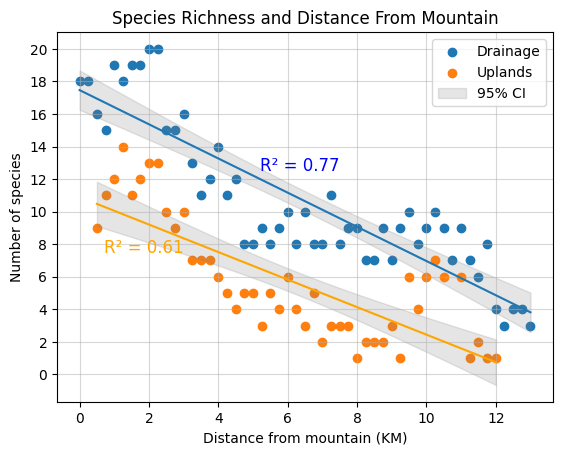

In [29]:
plt.scatter(tdf[tdf.uplands == 0].distance, tdf[tdf.uplands == 0].richness, label = 'Drainage')
plt.plot(tdf[tdf.uplands == 0].distance, dmodel.fittedvalues)
plt.fill_between(tdf[tdf.uplands == 0].distance, dci_lower, dci_upper, color='gray', alpha=0.2)

plt.scatter(tdf[tdf.uplands == 1].distance, tdf[tdf.uplands == 1].richness, label = 'Uplands')
plt.plot(tdf[tdf.uplands == 1].distance, umodel.fittedvalues, color='orange')
plt.fill_between(tdf[tdf.uplands == 1].distance, uci_lower, uci_upper, color='gray', alpha=0.2, label='95% CI')

plt.yticks(range(0, 21, 2), range(0, 21, 2))
plt.legend()
plt.text(5.2, 12.5, f'R\u00b2 = {round(dr2, 2)}', fontsize = 12, color = 'blue')
plt.text(0.7, 7.5, f'R\u00b2 = {round(ur2, 2)}', fontsize = 12, color = 'orange')
plt.title('Species Richness and Distance From Mountain')
plt.xlabel('Distance from mountain (KM)')
plt.ylabel('Number of species')
plt.grid(':', alpha = 0.5)
plt.savefig("docs/distance_uplands_drainage.png", dpi=300, bbox_inches="tight")
plt.show()

## t-tests

In [30]:
paired_df = tdf[tdf.uplands == 1][['distance', 'richness']].merge(tdf[tdf.uplands == 0][['distance', 'richness']], left_on = 'distance', right_on = 'distance')
paired_df.rename(columns = {'richness_x' : 'upland_plants', 'richness_y' : 'drainage'}, inplace = True)

In [31]:
print('Drainages on average have', round((paired_df.drainage - paired_df.upland_plants).mean(), 2), 'more species than the adjacent uplands.')

Drainages on average have 5.33 more species than the adjacent uplands.


In [32]:
paired_df['diff'] = paired_df.drainage - paired_df.upland_plants

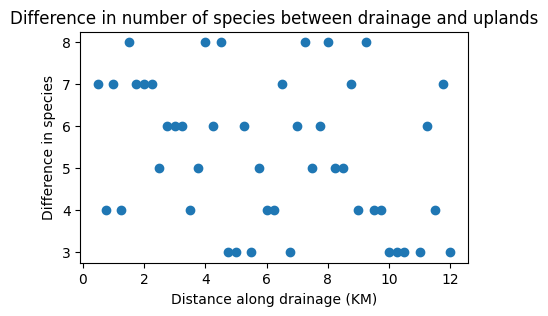

In [33]:
plt.figure(figsize = (5, 3))
plt.scatter(paired_df.distance, paired_df['diff'])
plt.title('Difference in number of species between drainage and uplands')
plt.ylabel('Difference in species')
plt.xlabel('Distance along drainage (KM)')
plt.show()

In [34]:
print('paired t-test p-value =', format(round(stats.ttest_rel(paired_df.upland_plants, paired_df.drainage).pvalue, 10), ".10f"))

paired t-test p-value = 0.0000000000


In [35]:
print('Independent sample t-test p-value =', format(round(stats.ttest_ind(paired_df.upland_plants, paired_df.drainage).pvalue, 10), ".10f"))

Independent sample t-test p-value = 0.0000000043


In [36]:
def statistic(x, y):
    return np.mean(x) - np.mean(y)

In [37]:
perm_test = stats.permutation_test(data=(paired_df.upland_plants, paired_df.drainage), statistic = statistic, n_resamples = 10000, alternative = 'less')
print('difference of means with 10,000 resample permutation p-value =', format(round(perm_test.pvalue, 10), ".10f"))

difference of means with 10,000 resample permutation p-value = 0.0000999900


In [38]:
print('ANCOVA difference between upland and drainage species regression p-value =', format(round(ancova(data = tdf, dv = 'richness', covar = 'distance', between = 'uplands')['p-unc'][0], 10), ".10f"))

ANCOVA difference between upland and drainage species regression p-value = 0.0000000000


# MDS

In [39]:
tdf['upland_drainage'] = tdf['uplands'] * 4 + tdf['Geomorphic surface']

In [40]:
tdf.drop(columns = {'richness', 'distance', 'site'}, inplace = True)

In [41]:
tdf.drop(columns = ['S.mex'], inplace = True)

## Uplands

In [42]:
transformer = QuantileTransformer(output_distribution='normal', n_quantiles = 5)
transformed = transformer.fit_transform(tdf[tdf.uplands.isin([1])].drop(columns = ['Geomorphic surface', 'uplands', 'upland_drainage']))

In [43]:
#scaled_tdf = pd.DataFrame(scaled)
scaled_tdf = pd.DataFrame(transformed)
scaled_tdf.columns = tdf.columns[:-3]

In [44]:
mds = MDS(n_components = 3, max_iter = 100000, metric = False, dissimilarity = 'precomputed')

dist = DistanceMetric.get_metric('braycurtis')
#dist = DistanceMetric.get_metric('euclidean')

mdsx = pd.DataFrame(mds.fit_transform(dist.pairwise(scaled_tdf)))
mds.stress_

np.float64(0.06347997893547468)

In [45]:
mdsx.columns = ['b-mds0', 'b-mds1', 'b-mds2']
mdsx['Geomorphic surface'] = tdf['Geomorphic surface']
mdsx['uplands'] = tdf['uplands']

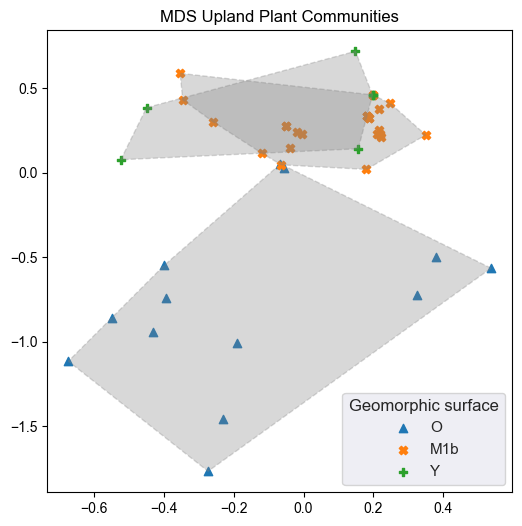

In [46]:
labels = mdsx['Geomorphic surface'].unique()

fig, ax = plt.subplots(figsize = (6,6))
sns.set()

for label, l, s in zip(labels, ['O', 'M1b', 'Y', 'Yr'], ['^', 'X', 'P', ',']):  #zip(labels, ['Drainage', 'Uplands'], ['^', 'X']):
    group_df = mdsx[mdsx['Geomorphic surface'] == label]
    points = group_df[['b-mds1', 'b-mds0']].values
    ax.scatter(group_df['b-mds1'], group_df['b-mds0'], label = l, edgecolor = None, marker = s)
    if len(points) > 2:
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        poly = patches.Polygon(polygon_points, alpha = 0.3, fill = True, linestyle ='--', color = 'gray')
        ax.add_patch(poly)
        
plt.legend(title = 'Geomorphic surface')
plt.title('MDS Upland Plant Communities')
plt.savefig("docs/uplands_mds.png", dpi=300, bbox_inches="tight")
plt.show()

## Drainage

In [47]:
transformer = QuantileTransformer(output_distribution='normal', n_quantiles = 5) 
transformed = transformer.fit_transform(tdf[tdf.uplands.isin([0])].drop(columns = ['Geomorphic surface', 'uplands', 'upland_drainage']))

In [48]:
#scaled_tdf = pd.DataFrame(scaled)
scaled_tdf = pd.DataFrame(transformed)
scaled_tdf.columns = tdf.columns[:-3]

In [49]:
mds = MDS(n_components = 3, max_iter = 100000, metric = False, dissimilarity = 'precomputed')

dist = DistanceMetric.get_metric('braycurtis')
#dist = DistanceMetric.get_metric('euclidean')

mdsx = pd.DataFrame(mds.fit_transform(dist.pairwise(scaled_tdf)))
mds.stress_

np.float64(0.09688237217375166)

In [50]:
mdsx.columns = ['b-mds0', 'b-mds1', 'b-mds2']
mdsx['Geomorphic surface'] = tdf['Geomorphic surface']
mdsx['uplands'] = tdf['uplands']

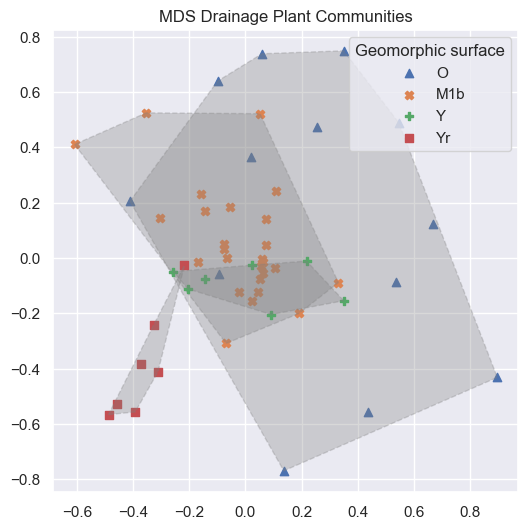

In [51]:
labels = mdsx['Geomorphic surface'].unique()

fig, ax = plt.subplots(figsize = (6,6))
sns.set()

for label, l, s in zip(labels, ['O', 'M1b', 'Y', 'Yr'], ['^', 'X', 'P', ',']):  #zip(labels, ['Drainage', 'Uplands'], ['^', 'X']):
    group_df = mdsx[mdsx['Geomorphic surface'] == label]
    points = group_df[['b-mds0', 'b-mds1']].values
    ax.scatter(group_df['b-mds0'], group_df['b-mds1'], label = l, edgecolor = None, marker = s)
    if len(points) > 2:
        hull = ConvexHull(points)
        polygon_points = points[hull.vertices]
        poly = patches.Polygon(polygon_points, alpha = 0.3, fill = True, linestyle ='--', color = 'gray')
        ax.add_patch(poly)
        
plt.legend(title = 'Geomorphic surface')
plt.title('MDS Drainage Plant Communities')
plt.savefig("docs/drainage_mds.png", dpi=300, bbox_inches="tight")
plt.show()

## Upland and drainage

In [52]:
transformer = QuantileTransformer(output_distribution='normal', n_quantiles = 5) 
transformed = transformer.fit_transform(tdf.drop(columns = ['Geomorphic surface', 'uplands', 'upland_drainage']))

scaled_tdf = pd.DataFrame(transformed)
scaled_tdf.columns = tdf.columns[:-3]

mds = MDS(n_components = 3, max_iter = 100000, metric = False, dissimilarity = 'precomputed')

dist = DistanceMetric.get_metric('braycurtis')
#dist = DistanceMetric.get_metric('euclidean')

mdsx = pd.DataFrame(mds.fit_transform(dist.pairwise(scaled_tdf)))
mds.stress_

np.float64(0.09530701572034558)

In [53]:
mdsx.columns = ['b-mds0', 'b-mds1', 'b-mds2']
mdsx['upland_drainage'] = tdf['upland_drainage']
mdsx['uplands'] = tdf['uplands']

surface = ['O drainage', 'M1b drainage', 'Y drainage', 'Yr drainage', 'O upland', 'M1b upland', 'Y upland'] #, 'Yr upland'
mrk = ['^', 'X', 'P', ',', '1', '2', '3', '4']

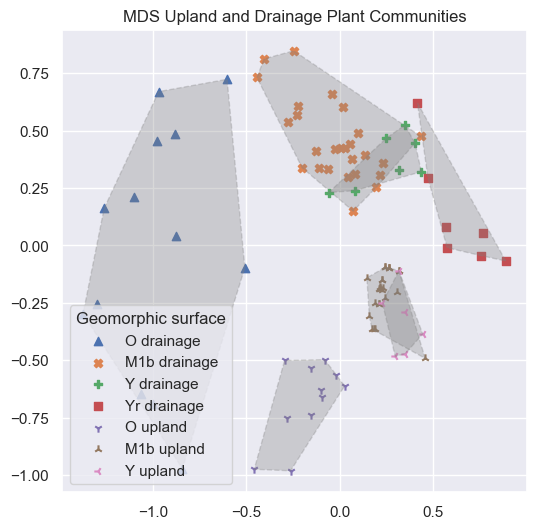

In [54]:
labels = mdsx['upland_drainage'].unique()

fig, ax = plt.subplots(figsize=(6,6))
sns.set()

for label, l, s in zip(labels, surface, mrk):
    group_df = mdsx[mdsx['upland_drainage'] == label]
    points = group_df[['b-mds0', 'b-mds2']].values

    # scatter points
    ax.scatter(group_df['b-mds0'], group_df['b-mds2'], 
               label=l, edgecolor=None, marker=s)

    # convex hull only if >= 3 unique points
    if len(points) >= 3:
        unique_points = np.unique(points, axis=0)
        if len(unique_points) >= 3:  # need at least 3 non-collinear points
            try:
                hull = ConvexHull(unique_points)
                polygon_points = unique_points[hull.vertices]
                poly = patches.Polygon(polygon_points, alpha=0.3, 
                                       fill=True, linestyle='--', color='gray')
                ax.add_patch(poly)
            except Exception as e:
                print(f"Skipping hull for {label}: {e}")

plt.legend(title='Geomorphic surface')
plt.title('MDS Upland and Drainage Plant Communities')
plt.savefig("docs/upland_drainage_mds.png", dpi=300, bbox_inches="tight")
plt.show()

# Permutaion hypothesis testing

# Random Forest

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X, y)

In [ ]:
rfc.score(X, y)

In [ ]:
y_pred = rfc.predict(X)
confusion_matrix(y, y_pred)

In [ ]:
y.value_counts().sort_index()